In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.auto import tqdm

%matplotlib inline

In [2]:
def f1_score(y_true, y_pred):
    y_true = y_true.apply(lambda x: set(x.split()))
    y_pred = y_pred.apply(lambda x: set(x.split()))
    intersection = np.array([len(x[0] & x[1]) for x in zip(y_true, y_pred)])
    len_y_pred = y_pred.apply(lambda x: len(x)).values
    len_y_true = y_true.apply(lambda x: len(x)).values
    f1 = 2 * intersection / (len_y_pred + len_y_true)
    return f1

def combine_predictions(row):
    x = np.concatenate([row['image_predictions'], row['text_predictions']])
    return ' '.join( np.unique(x) )

def match_algo_interpolation_train(submit_df):
    match_dic = {}
    
    def count_match(row):
        return len(row["pred_matches"].split())-1
    
    def match_diff(row):
        posting_id = np.array(row["posting_id"])
        pred_matches = np.array(row["pred_matches"].split())
        pred_match = np.array(np.setdiff1d(pred_matches, posting_id)).tolist()
        if row["match_num"] > 0:
            return " ".join(pred_match)
        else:
            return

    def get_match_dic(row):
        if row["match_num"] > 0:
            if not match_dic.get(row["pred_match"]):
                match_dic[row["pred_match"]] = [row["posting_id"]]
            else:
                match_dic[row["pred_match"]].append(row["posting_id"])

    def join_list():
        for k, v in match_dic.items():
            match_dic[k] = " ".join(v)

    def column_merge(row):
        if row["match_num"] > 0:
            x = row['pred_matches'] + " " + row['posting_id_2']
            x = np.array(x.split())
            return ' '.join( np.unique(x) )
        else:
            return row['pred_matches']
        
    submit_df['match_num'] = submit_df.apply(count_match, axis=1)
    submit_df['pred_match'] = submit_df.apply(match_diff, axis=1)
    submit_df.apply(get_match_dic, axis=1)
    
    join_list()
    match_df = pd.DataFrame.from_dict(match_dic, orient='index')
    match_df = match_df.reset_index()
    match_df = match_df.rename(columns = {'index': 'pred_match', 0: 'posting_id_2'}, inplace = False)
    
    submit_df = pd.merge(submit_df, match_df, on='pred_match', how='left')
    submit_df["pred_matches_2"] = submit_df.apply(column_merge, axis=1)
    
    submit_df['f1_1'] = f1_score(submit_df['matches'], submit_df['pred_matches'])
    submit_df['f1_2'] = f1_score(submit_df['matches'], submit_df['pred_matches_2'])

    score_1 = submit_df['f1_1'].mean()
    score_2 = submit_df['f1_2'].mean()

    print(f'Our final f1 origin cv score is {score_1}')
    print(f'Our final f1 match algo cv score is {score_2}')
    
    submit_df_2 = pd.DataFrame()
    submit_df_2[['posting_id', 'pred_matches']] = submit_df[['posting_id', 'pred_matches_2']]
    return submit_df_2

def match_algo_interpolation_inference(submit_df):
    match_dic = {}
    
    def count_match(row):
        return len(row["matches"].split())-1
    
    def match_diff(row):
        posting_id = np.array(row["posting_id"])
        pred_matches = np.array(row["matches"].split())
        pred_match = np.array(np.setdiff1d(pred_matches, posting_id)).tolist()
        if row["match_num"] > 0:
            return " ".join(pred_match)
        else:
            return row["matches"]

    def get_match_dic(row):
        if row["match_num"] > 0:
            if not match_dic.get(row["matches"]):
                match_dic[row["matches"]] = [row["posting_id"]]
            else:
                match_dic[row["matches"]].append(row["posting_id"])

    def join_list():
        for k, v in match_dic.items():
            match_dic[k] = " ".join(v)

    def column_merge(row):
        if row["match_num"] > 0:
            x = row['matches'] + " " + row['posting_id_2']
            x = np.array(x.split())
            return ' '.join( np.unique(x) )
        else:
            return row['matches']
        
    submit_df['match_num'] = submit_df.apply(count_match, axis=1)
    submit_df['matches'] = submit_df.apply(match_diff, axis=1)
    submit_df.apply(get_match_dic, axis=1)
    
    join_list()
    match_df = pd.DataFrame.from_dict(match_dic, orient='index')
    match_df = match_df.reset_index()
    match_df = match_df.rename(columns = {'index': 'matches', 0: 'posting_id_2'}, inplace = False)
    
    submit_df = pd.merge(submit_df, match_df, on='matches', how='left')
    submit_df["pred_matches_2"] = submit_df.apply(column_merge, axis=1)
    
    submit_df_2 = pd.DataFrame()
    submit_df_2[['posting_id', 'matches']] = submit_df[['posting_id', 'pred_matches_2']]
    return submit_df_2

In [3]:
df = pd.read_pickle('../input/shopee-008-seresnext-infer-data/oof_df.pkl').reset_index(drop=True)

In [4]:
df.head()

,posting_id,image,image_phash,title,label_group,fold,matches,file_path,image_predictions,text_predictions_tfidf,text_predictions_bert,text_predictions_bert_len,text_predictions,pred_matches,f1
0,train_1802986387,00144a49c56599d45354a1c28104c039.jpg,f815c9bb833ab4c8,Jubah anak size 1-12 thn,1835033137,0,train_1802986387 train_1396161074 train_713073...,../input/shopee-product-matching/train_images/...,[train_1802986387],[train_1802986387],"[train_1802986387, train_1396161074, train_249...",3,[train_1802986387],train_1802986387,0.25
1,train_1598329973,001d7f5d9a2fac714f4d5f37b3baffb4.jpg,bec8d09693634b4b,Atasan Rajut Wanita LISDIA SWEATER,2462407944,0,train_1598329973 train_841015183 train_4224502769,../input/shopee-product-matching/train_images/...,[train_1598329973],"[train_1598329973, train_841015183, train_4224...","[train_1598329973, train_841015183, train_4224...",3,"[train_1598329973, train_841015183, train_4224...",train_1598329973 train_4224502769 train_841015183,1.00
2,train_4196427721,002039aaf8618627a0442d5e89e5dda6.jpg,e98c873acc65946e,Korek Kuping LED untuk balita CherryBabyKidsSh...,349297863,0,train_4196427721 train_1482447822 train_234660...,../input/shopee-product-matching/train_images/...,"[train_4196427721, train_2221959828, train_375...",[train_4196427721],[train_4196427721],1,[train_4196427721],train_1482447822 train_1815218122 train_222195...,1.00
3,train_2985955659,002f978c58a44a00aadfca71c3cad2bb.jpg,bf38f0e083d7c710,HnKfashion Sweater Hoodie WHO Printing BabyTer...,3415582503,0,train_2985955659 train_3916258742 train_415673...,../input/shopee-product-matching/train_images/...,"[train_2985955659, train_4156734436, train_391...",[train_2985955659],"[train_2985955659, train_3916258742, train_415...",3,[train_2985955659],train_2985955659 train_3916258742 train_415673...,1.00
4,train_3466601092,004076b57135e761ab8b41d84acc4c94.jpg,aa2c0ee4eb6ba0cd,[Shiyan] mainan gigitan bayi set pack baby tee...,2933791615,0,train_3466601092 train_354147588,../input/shopee-product-matching/train_images/...,"[train_3466601092, train_354147588]",[train_3466601092],[train_3466601092],1,[train_3466601092],train_3466601092 train_354147588,1.00


In [5]:
df['matches_len'] = df['matches'].apply(lambda x: len(x.split()))
df['pred_matches_len'] = df['pred_matches'].apply(lambda x: len(x.split()))
df['image_predictions_len'] = df['image_predictions'].apply(lambda x: len(x))
df['text_predictions_len'] = df['text_predictions'].apply(lambda x: len(x))
df['text_predictions_bert_len'] = df['text_predictions_bert'].apply(lambda x: len(x))
df['text_predictions_tfidf_len'] = df['text_predictions_tfidf'].apply(lambda x: len(x))

In [6]:
df.head()

,posting_id,image,image_phash,title,label_group,fold,matches,file_path,image_predictions,text_predictions_tfidf,text_predictions_bert,text_predictions_bert_len,text_predictions,pred_matches,f1,matches_len,pred_matches_len,image_predictions_len,text_predictions_len,text_predictions_tfidf_len
0,train_1802986387,00144a49c56599d45354a1c28104c039.jpg,f815c9bb833ab4c8,Jubah anak size 1-12 thn,1835033137,0,train_1802986387 train_1396161074 train_713073...,../input/shopee-product-matching/train_images/...,[train_1802986387],[train_1802986387],"[train_1802986387, train_1396161074, train_249...",3,[train_1802986387],train_1802986387,0.25,7,1,1,1,1
1,train_1598329973,001d7f5d9a2fac714f4d5f37b3baffb4.jpg,bec8d09693634b4b,Atasan Rajut Wanita LISDIA SWEATER,2462407944,0,train_1598329973 train_841015183 train_4224502769,../input/shopee-product-matching/train_images/...,[train_1598329973],"[train_1598329973, train_841015183, train_4224...","[train_1598329973, train_841015183, train_4224...",3,"[train_1598329973, train_841015183, train_4224...",train_1598329973 train_4224502769 train_841015183,1.00,3,3,1,3,3
2,train_4196427721,002039aaf8618627a0442d5e89e5dda6.jpg,e98c873acc65946e,Korek Kuping LED untuk balita CherryBabyKidsSh...,349297863,0,train_4196427721 train_1482447822 train_234660...,../input/shopee-product-matching/train_images/...,"[train_4196427721, train_2221959828, train_375...",[train_4196427721],[train_4196427721],1,[train_4196427721],train_1482447822 train_1815218122 train_222195...,1.00,8,8,8,1,1
3,train_2985955659,002f978c58a44a00aadfca71c3cad2bb.jpg,bf38f0e083d7c710,HnKfashion Sweater Hoodie WHO Printing BabyTer...,3415582503,0,train_2985955659 train_3916258742 train_415673...,../input/shopee-product-matching/train_images/...,"[train_2985955659, train_4156734436, train_391...",[train_2985955659],"[train_2985955659, train_3916258742, train_415...",3,[train_2985955659],train_2985955659 train_3916258742 train_415673...,1.00,3,3,3,1,1
4,train_3466601092,004076b57135e761ab8b41d84acc4c94.jpg,aa2c0ee4eb6ba0cd,[Shiyan] mainan gigitan bayi set pack baby tee...,2933791615,0,train_3466601092 train_354147588,../input/shopee-product-matching/train_images/...,"[train_3466601092, train_354147588]",[train_3466601092],[train_3466601092],1,[train_3466601092],train_3466601092 train_354147588,1.00,2,2,2,1,1


/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


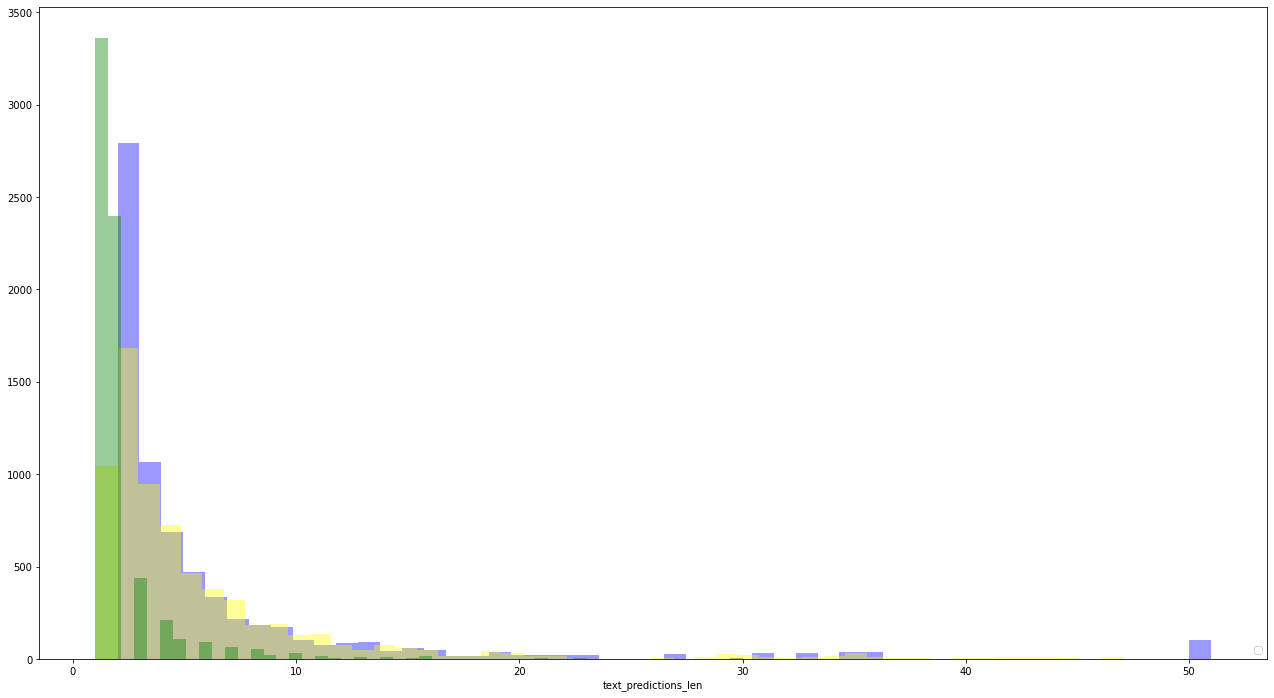

In [7]:
plt.figure(figsize=(22, 12))
sns.distplot(df['matches_len'], kde=False, color='blue')
# sns.distplot(Eff03_tfidf['pred_matches_len'], kde=False, color='red')
sns.distplot(df['image_predictions_len'], kde=False, color='yellow')
sns.distplot(df['text_predictions_len'], kde=False, color='green')
plt.legend(loc=4)
plt.show()

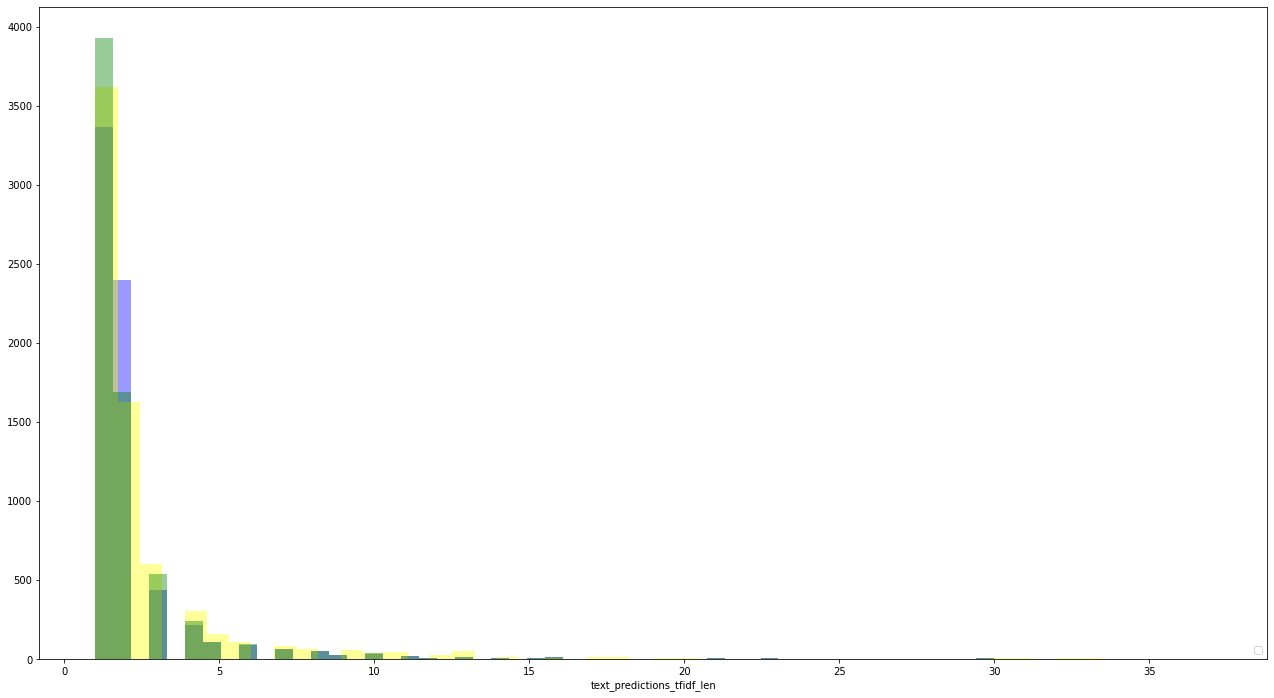

In [8]:
plt.figure(figsize=(22, 12))
sns.distplot(df['text_predictions_len'], kde=False, color='blue')
sns.distplot(df['text_predictions_bert_len'], kde=False, color='yellow')
sns.distplot(df['text_predictions_tfidf_len'], kde=False, color='green')
plt.legend(loc=4)
plt.show()

In [9]:
df['text_predictions'] = df['text_predictions_tfidf']
df['pred_matches'] = df.apply(combine_predictions, axis=1)
df['f1_tfidf'] = f1_score(df['matches'], df['pred_matches'])
df['f1_tfidf'].mean()

0.8184035503868264

In [10]:
df['text_predictions'] = df['text_predictions_bert']
df['pred_matches'] = df.apply(combine_predictions, axis=1)
df['f1_bert'] = f1_score(df['matches'], df['pred_matches'])
df['f1_bert'].mean()

0.8196925363673699

In [11]:
print(df[df['matches_len'] == 2]['f1_tfidf'].mean())
print(df[df['matches_len'] == 2]['f1_bert'].mean())

0.8155400011029541
0.8139555453607904


In [12]:
print(df[df['matches_len'] == 3]['f1_tfidf'].mean())
print(df[df['matches_len'] == 3]['f1_bert'].mean())

0.817146910184662
0.812933967488573


In [13]:
print(df[df['matches_len'] > 30]['f1_tfidf'].mean())
print(df[df['matches_len'] > 30]['f1_bert'].mean())

0.8220728094968244
0.8510438135023585


In [14]:
print(df[df['matches_len'] > 40]['f1_tfidf'].mean())
print(df[df['matches_len'] > 40]['f1_bert'].mean())

0.8111647165511474
0.8449033219004978


In [15]:
print(df[df['text_predictions_bert_len'] == 2]['f1_tfidf'].mean())
print(df[df['text_predictions_bert_len'] == 2]['f1_bert'].mean())

0.8531573632661897
0.8686707311635948


In [16]:
print(df[df['text_predictions_bert_len'] == 3]['f1_tfidf'].mean())
print(df[df['text_predictions_bert_len'] == 3]['f1_bert'].mean())

0.8542924535233809
0.8688879506517394


In [17]:
print(df[df['text_predictions_bert_len'] > 30]['f1_tfidf'].mean())
print(df[df['text_predictions_bert_len'] > 30]['f1_bert'].mean())

0.8461673900089179
0.942208200712981


In [18]:
print(len(df[df['pred_matches_len'] == 1]))
print(len(df[df['text_predictions_bert_len'] == 1]))
print(len(df[df['text_predictions_tfidf_len'] == 1]))

622
3619
3931


In [19]:
df['f1_tfidf'].mean()

0.8184035503868264

In [20]:
df['text_predictions'] = df['text_predictions_tfidf'].mask(df['text_predictions_bert_len']==2,
                                                           df['text_predictions_bert'])
df['pred_matches'] = df.apply(combine_predictions, axis=1)
df['pred_matches_len'] = df['pred_matches'].apply(lambda x: len(x.split()))
print(len(df[df['pred_matches_len']==1]))
df['f1'] = f1_score(df['matches'], df['pred_matches'])
df['f1'].mean()

622


0.8220854561233877

In [21]:
df['text_predictions'] = df['text_predictions_tfidf'].mask(df['text_predictions_tfidf_len']==1,
                                                           df['text_predictions_bert'])
df['pred_matches'] = df.apply(combine_predictions, axis=1)
df['pred_matches_len'] = df['pred_matches'].apply(lambda x: len(x.split()))
print(len(df[df['pred_matches_len']==1]))
df['f1'] = f1_score(df['matches'], df['pred_matches'])
df['f1'].mean()

607


0.8255292311762574

In [22]:
df['text_predictions'] = df['text_predictions_tfidf'].mask((df['text_predictions_tfidf_len'] == 1) | (df['text_predictions_bert_len']==2),
                                                           df['text_predictions_bert'])
df['pred_matches'] = df.apply(combine_predictions, axis=1)
df['f1'] = f1_score(df['matches'], df['pred_matches'])
df['f1'].mean()

0.8246906913338223

In [23]:
df['text_predictions'] = df['text_predictions_tfidf'].mask(df['text_predictions_bert_len'] > 30,
                                                           df['text_predictions_bert'])
df['pred_matches'] = df.apply(combine_predictions, axis=1)
df['pred_matches_len'] = df['pred_matches'].apply(lambda x: len(x.split()))
print(len(df[df['pred_matches_len']==1]))
df['f1'] = f1_score(df['matches'], df['pred_matches'])
df['f1'].mean()

704


0.818683920583014

In [24]:
df_notmatch = df[df['pred_matches_len']==1]
df_notmatch['label_group'].nunique()

446

In [25]:
diff_list = []
for i, label in enumerate(df_notmatch['label_group'].unique()):
    before = len(df[df['label_group']==label]) 
    after = len(df_notmatch[df_notmatch['label_group']==label])
    diff = before - after
    diff_list.append(diff)
#     print(before, after)
#     if i > 10:
#         break

In [26]:
np.mean(diff_list)

1.6188340807174888

In [27]:
df_notmatch['f1'].mean()

0.5686968426564897

In [28]:
df.head()

,posting_id,image,image_phash,title,label_group,fold,matches,file_path,image_predictions,text_predictions_tfidf,...,text_predictions,pred_matches,f1,matches_len,pred_matches_len,image_predictions_len,text_predictions_len,text_predictions_tfidf_len,f1_tfidf,f1_bert
0,train_1802986387,00144a49c56599d45354a1c28104c039.jpg,f815c9bb833ab4c8,Jubah anak size 1-12 thn,1835033137,0,train_1802986387 train_1396161074 train_713073...,../input/shopee-product-matching/train_images/...,[train_1802986387],[train_1802986387],...,[train_1802986387],train_1802986387,0.25,7,1,1,1,1,0.25,0.6
1,train_1598329973,001d7f5d9a2fac714f4d5f37b3baffb4.jpg,bec8d09693634b4b,Atasan Rajut Wanita LISDIA SWEATER,2462407944,0,train_1598329973 train_841015183 train_4224502769,../input/shopee-product-matching/train_images/...,[train_1598329973],"[train_1598329973, train_841015183, train_4224...",...,"[train_1598329973, train_841015183, train_4224...",train_1598329973 train_4224502769 train_841015183,1.00,3,3,1,3,3,1.00,1.0
2,train_4196427721,002039aaf8618627a0442d5e89e5dda6.jpg,e98c873acc65946e,Korek Kuping LED untuk balita CherryBabyKidsSh...,349297863,0,train_4196427721 train_1482447822 train_234660...,../input/shopee-product-matching/train_images/...,"[train_4196427721, train_2221959828, train_375...",[train_4196427721],...,[train_4196427721],train_1482447822 train_1815218122 train_222195...,1.00,8,8,8,1,1,1.00,1.0
3,train_2985955659,002f978c58a44a00aadfca71c3cad2bb.jpg,bf38f0e083d7c710,HnKfashion Sweater Hoodie WHO Printing BabyTer...,3415582503,0,train_2985955659 train_3916258742 train_415673...,../input/shopee-product-matching/train_images/...,"[train_2985955659, train_4156734436, train_391...",[train_2985955659],...,[train_2985955659],train_2985955659 train_3916258742 train_415673...,1.00,3,3,3,1,1,1.00,1.0
4,train_3466601092,004076b57135e761ab8b41d84acc4c94.jpg,aa2c0ee4eb6ba0cd,[Shiyan] mainan gigitan bayi set pack baby tee...,2933791615,0,train_3466601092 train_354147588,../input/shopee-product-matching/train_images/...,"[train_3466601092, train_354147588]",[train_3466601092],...,[train_3466601092],train_3466601092 train_354147588,1.00,2,2,2,1,1,1.00,1.0


In [29]:
df_ = match_algo_interpolation_train(df)
df_

Our final f1 origin cv score is 0.818683920583014
Our final f1 match algo cv score is 0.8195060844774148


,posting_id,pred_matches
0,train_1802986387,train_1802986387
1,train_1598329973,train_1598329973 train_4224502769 train_841015183
2,train_4196427721,train_1482447822 train_1815218122 train_222195...
3,train_2985955659,train_2985955659 train_3916258742 train_415673...
4,train_3466601092,train_3466601092 train_354147588
...,...,...
6846,train_259196128,train_259196128 train_3219916478
6847,train_3074398993,train_2919333796 train_3074398993
6848,train_3296417563,train_1569930350 train_3296417563
6849,train_945815402,train_945815402


In [30]:
df

,posting_id,image,image_phash,title,label_group,fold,matches,file_path,image_predictions,text_predictions_tfidf,...,f1,matches_len,pred_matches_len,image_predictions_len,text_predictions_len,text_predictions_tfidf_len,f1_tfidf,f1_bert,match_num,pred_match
0,train_1802986387,00144a49c56599d45354a1c28104c039.jpg,f815c9bb833ab4c8,Jubah anak size 1-12 thn,1835033137,0,train_1802986387 train_1396161074 train_713073...,../input/shopee-product-matching/train_images/...,[train_1802986387],[train_1802986387],...,0.250000,7,1,1,1,1,0.250000,0.600000,0,None
1,train_1598329973,001d7f5d9a2fac714f4d5f37b3baffb4.jpg,bec8d09693634b4b,Atasan Rajut Wanita LISDIA SWEATER,2462407944,0,train_1598329973 train_841015183 train_4224502769,../input/shopee-product-matching/train_images/...,[train_1598329973],"[train_1598329973, train_841015183, train_4224...",...,1.000000,3,3,1,3,3,1.000000,1.000000,2,train_4224502769 train_841015183
2,train_4196427721,002039aaf8618627a0442d5e89e5dda6.jpg,e98c873acc65946e,Korek Kuping LED untuk balita CherryBabyKidsSh...,349297863,0,train_4196427721 train_1482447822 train_234660...,../input/shopee-product-matching/train_images/...,"[train_4196427721, train_2221959828, train_375...",[train_4196427721],...,1.000000,8,8,8,1,1,1.000000,1.000000,7,train_1482447822 train_1815218122 train_222195...
3,train_2985955659,002f978c58a44a00aadfca71c3cad2bb.jpg,bf38f0e083d7c710,HnKfashion Sweater Hoodie WHO Printing BabyTer...,3415582503,0,train_2985955659 train_3916258742 train_415673...,../input/shopee-product-matching/train_images/...,"[train_2985955659, train_4156734436, train_391...",[train_2985955659],...,1.000000,3,3,3,1,1,1.000000,1.000000,2,train_3916258742 train_4156734436
4,train_3466601092,004076b57135e761ab8b41d84acc4c94.jpg,aa2c0ee4eb6ba0cd,[Shiyan] mainan gigitan bayi set pack baby tee...,2933791615,0,train_3466601092 train_354147588,../input/shopee-product-matching/train_images/...,"[train_3466601092, train_354147588]",[train_3466601092],...,1.000000,2,2,2,1,1,1.000000,1.000000,1,train_354147588
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6846,train_259196128,ffcd708bcca72f3f9aacd2a50a8827f3.jpg,e7930c6e96635394,Power Bank VEGER Ultimate X10 PRO 10.000Mah LE...,606327911,0,train_3219916478 train_259196128,../input/shopee-product-matching/train_images/...,"[train_259196128, train_3219916478]",[train_259196128],...,1.000000,2,2,2,1,1,1.000000,1.000000,1,train_3219916478
6847,train_3074398993,ffd6946ca482bf8ddcc2171997c395e8.jpg,f2e00f95790f702e,Bebelac 4 Vanila Susu Bubuk 800 gr,2317723557,0,train_2919333796 train_3074398993,../input/shopee-product-matching/train_images/...,"[train_3074398993, train_2919333796]","[train_2919333796, train_3074398993]",...,1.000000,2,2,2,2,2,1.000000,1.000000,1,train_2919333796
6848,train_3296417563,ffda9710b76ca85f004518e7f243f3fc.jpg,af26e0f0d3d2f02c,Gunting Kuku Bayi Reliable 2in1 /Baby Nail Cli...,2077239619,0,train_1569930350 train_3296417563,../input/shopee-product-matching/train_images/...,"[train_3296417563, train_1569930350]","[train_1569930350, train_3296417563]",...,1.000000,2,2,2,2,2,1.000000,1.000000,1,train_1569930350
6849,train_945815402,fff1222750374ddbed82b17c8bd2766d.jpg,b0cbce308fcdcc64,Baterai Batre Battery Xiaomi Redmi Note 3 BM46...,3091541662,0,train_601331882 train_945815402,../input/shopee-product-matching/train_images/...,[train_945815402],[train_945815402],...,0.666667,2,1,1,1,1,0.666667,0.666667,0,None


In [31]:
df = df.drop('match_num' , axis=1)
df = df.drop('pred_match', axis=1)
df

,posting_id,image,image_phash,title,label_group,fold,matches,file_path,image_predictions,text_predictions_tfidf,...,text_predictions,pred_matches,f1,matches_len,pred_matches_len,image_predictions_len,text_predictions_len,text_predictions_tfidf_len,f1_tfidf,f1_bert
0,train_1802986387,00144a49c56599d45354a1c28104c039.jpg,f815c9bb833ab4c8,Jubah anak size 1-12 thn,1835033137,0,train_1802986387 train_1396161074 train_713073...,../input/shopee-product-matching/train_images/...,[train_1802986387],[train_1802986387],...,[train_1802986387],train_1802986387,0.250000,7,1,1,1,1,0.250000,0.600000
1,train_1598329973,001d7f5d9a2fac714f4d5f37b3baffb4.jpg,bec8d09693634b4b,Atasan Rajut Wanita LISDIA SWEATER,2462407944,0,train_1598329973 train_841015183 train_4224502769,../input/shopee-product-matching/train_images/...,[train_1598329973],"[train_1598329973, train_841015183, train_4224...",...,"[train_1598329973, train_841015183, train_4224...",train_1598329973 train_4224502769 train_841015183,1.000000,3,3,1,3,3,1.000000,1.000000
2,train_4196427721,002039aaf8618627a0442d5e89e5dda6.jpg,e98c873acc65946e,Korek Kuping LED untuk balita CherryBabyKidsSh...,349297863,0,train_4196427721 train_1482447822 train_234660...,../input/shopee-product-matching/train_images/...,"[train_4196427721, train_2221959828, train_375...",[train_4196427721],...,[train_4196427721],train_1482447822 train_1815218122 train_222195...,1.000000,8,8,8,1,1,1.000000,1.000000
3,train_2985955659,002f978c58a44a00aadfca71c3cad2bb.jpg,bf38f0e083d7c710,HnKfashion Sweater Hoodie WHO Printing BabyTer...,3415582503,0,train_2985955659 train_3916258742 train_415673...,../input/shopee-product-matching/train_images/...,"[train_2985955659, train_4156734436, train_391...",[train_2985955659],...,[train_2985955659],train_2985955659 train_3916258742 train_415673...,1.000000,3,3,3,1,1,1.000000,1.000000
4,train_3466601092,004076b57135e761ab8b41d84acc4c94.jpg,aa2c0ee4eb6ba0cd,[Shiyan] mainan gigitan bayi set pack baby tee...,2933791615,0,train_3466601092 train_354147588,../input/shopee-product-matching/train_images/...,"[train_3466601092, train_354147588]",[train_3466601092],...,[train_3466601092],train_3466601092 train_354147588,1.000000,2,2,2,1,1,1.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6846,train_259196128,ffcd708bcca72f3f9aacd2a50a8827f3.jpg,e7930c6e96635394,Power Bank VEGER Ultimate X10 PRO 10.000Mah LE...,606327911,0,train_3219916478 train_259196128,../input/shopee-product-matching/train_images/...,"[train_259196128, train_3219916478]",[train_259196128],...,[train_259196128],train_259196128 train_3219916478,1.000000,2,2,2,1,1,1.000000,1.000000
6847,train_3074398993,ffd6946ca482bf8ddcc2171997c395e8.jpg,f2e00f95790f702e,Bebelac 4 Vanila Susu Bubuk 800 gr,2317723557,0,train_2919333796 train_3074398993,../input/shopee-product-matching/train_images/...,"[train_3074398993, train_2919333796]","[train_2919333796, train_3074398993]",...,"[train_2919333796, train_3074398993]",train_2919333796 train_3074398993,1.000000,2,2,2,2,2,1.000000,1.000000
6848,train_3296417563,ffda9710b76ca85f004518e7f243f3fc.jpg,af26e0f0d3d2f02c,Gunting Kuku Bayi Reliable 2in1 /Baby Nail Cli...,2077239619,0,train_1569930350 train_3296417563,../input/shopee-product-matching/train_images/...,"[train_3296417563, train_1569930350]","[train_1569930350, train_3296417563]",...,"[train_1569930350, train_3296417563]",train_1569930350 train_3296417563,1.000000,2,2,2,2,2,1.000000,1.000000
6849,train_945815402,fff1222750374ddbed82b17c8bd2766d.jpg,b0cbce308fcdcc64,Baterai Batre Battery Xiaomi Redmi Note 3 BM46...,3091541662,0,train_601331882 train_945815402,../input/shopee-product-matching/train_images/...,[train_945815402],[train_945815402],...,[train_945815402],train_945815402,0.666667,2,1,1,1,1,0.666667,0.666667


In [32]:
df['pred_matches_afteralgo'] = df_['pred_matches']
df['pred_matches_afteralgo_len'] = df['pred_matches_afteralgo'].apply(lambda x: len(x.split()))
df['f1_afteralgo'] = f1_score(df['matches'], df['pred_matches_afteralgo'])
df

,posting_id,image,image_phash,title,label_group,fold,matches,file_path,image_predictions,text_predictions_tfidf,...,matches_len,pred_matches_len,image_predictions_len,text_predictions_len,text_predictions_tfidf_len,f1_tfidf,f1_bert,pred_matches_afteralgo,pred_matches_afteralgo_len,f1_afteralgo
0,train_1802986387,00144a49c56599d45354a1c28104c039.jpg,f815c9bb833ab4c8,Jubah anak size 1-12 thn,1835033137,0,train_1802986387 train_1396161074 train_713073...,../input/shopee-product-matching/train_images/...,[train_1802986387],[train_1802986387],...,7,1,1,1,1,0.250000,0.600000,train_1802986387,1,0.250000
1,train_1598329973,001d7f5d9a2fac714f4d5f37b3baffb4.jpg,bec8d09693634b4b,Atasan Rajut Wanita LISDIA SWEATER,2462407944,0,train_1598329973 train_841015183 train_4224502769,../input/shopee-product-matching/train_images/...,[train_1598329973],"[train_1598329973, train_841015183, train_4224...",...,3,3,1,3,3,1.000000,1.000000,train_1598329973 train_4224502769 train_841015183,3,1.000000
2,train_4196427721,002039aaf8618627a0442d5e89e5dda6.jpg,e98c873acc65946e,Korek Kuping LED untuk balita CherryBabyKidsSh...,349297863,0,train_4196427721 train_1482447822 train_234660...,../input/shopee-product-matching/train_images/...,"[train_4196427721, train_2221959828, train_375...",[train_4196427721],...,8,8,8,1,1,1.000000,1.000000,train_1482447822 train_1815218122 train_222195...,8,1.000000
3,train_2985955659,002f978c58a44a00aadfca71c3cad2bb.jpg,bf38f0e083d7c710,HnKfashion Sweater Hoodie WHO Printing BabyTer...,3415582503,0,train_2985955659 train_3916258742 train_415673...,../input/shopee-product-matching/train_images/...,"[train_2985955659, train_4156734436, train_391...",[train_2985955659],...,3,3,3,1,1,1.000000,1.000000,train_2985955659 train_3916258742 train_415673...,3,1.000000
4,train_3466601092,004076b57135e761ab8b41d84acc4c94.jpg,aa2c0ee4eb6ba0cd,[Shiyan] mainan gigitan bayi set pack baby tee...,2933791615,0,train_3466601092 train_354147588,../input/shopee-product-matching/train_images/...,"[train_3466601092, train_354147588]",[train_3466601092],...,2,2,2,1,1,1.000000,1.000000,train_3466601092 train_354147588,2,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6846,train_259196128,ffcd708bcca72f3f9aacd2a50a8827f3.jpg,e7930c6e96635394,Power Bank VEGER Ultimate X10 PRO 10.000Mah LE...,606327911,0,train_3219916478 train_259196128,../input/shopee-product-matching/train_images/...,"[train_259196128, train_3219916478]",[train_259196128],...,2,2,2,1,1,1.000000,1.000000,train_259196128 train_3219916478,2,1.000000
6847,train_3074398993,ffd6946ca482bf8ddcc2171997c395e8.jpg,f2e00f95790f702e,Bebelac 4 Vanila Susu Bubuk 800 gr,2317723557,0,train_2919333796 train_3074398993,../input/shopee-product-matching/train_images/...,"[train_3074398993, train_2919333796]","[train_2919333796, train_3074398993]",...,2,2,2,2,2,1.000000,1.000000,train_2919333796 train_3074398993,2,1.000000
6848,train_3296417563,ffda9710b76ca85f004518e7f243f3fc.jpg,af26e0f0d3d2f02c,Gunting Kuku Bayi Reliable 2in1 /Baby Nail Cli...,2077239619,0,train_1569930350 train_3296417563,../input/shopee-product-matching/train_images/...,"[train_3296417563, train_1569930350]","[train_1569930350, train_3296417563]",...,2,2,2,2,2,1.000000,1.000000,train_1569930350 train_3296417563,2,1.000000
6849,train_945815402,fff1222750374ddbed82b17c8bd2766d.jpg,b0cbce308fcdcc64,Baterai Batre Battery Xiaomi Redmi Note 3 BM46...,3091541662,0,train_601331882 train_945815402,../input/shopee-product-matching/train_images/...,[train_945815402],[train_945815402],...,2,1,1,1,1,0.666667,0.666667,train_945815402,1,0.666667


In [33]:
print(df.columns)

Index(['posting_id', 'image', 'image_phash', 'title', 'label_group', 'fold',
       'matches', 'file_path', 'image_predictions', 'text_predictions_tfidf',
       'text_predictions_bert', 'text_predictions_bert_len',
       'text_predictions', 'pred_matches', 'f1', 'matches_len',
       'pred_matches_len', 'image_predictions_len', 'text_predictions_len',
       'text_predictions_tfidf_len', 'f1_tfidf', 'f1_bert',
       'pred_matches_afteralgo', 'pred_matches_afteralgo_len', 'f1_afteralgo'],
      dtype='object')


In [34]:
df_notmatch_afteralgo = df[df['pred_matches_afteralgo_len']==1]
df_notmatch_afteralgo['label_group'].nunique()

446

In [35]:
diff_list = []
for i, label in enumerate(df_notmatch['label_group'].unique()):
    before = len(df[df['label_group']==label]) 
    after = len(df_notmatch[df_notmatch['label_group']==label])
    diff = before - after
    diff_list.append(diff)
#     print(before, after)
#     if i > 20:
#         break

In [36]:
np.mean(diff_list)

1.6188340807174888

In [37]:
label = df_notmatch['label_group'].unique()[0]
df[df['label_group']==label]

,posting_id,image,image_phash,title,label_group,fold,matches,file_path,image_predictions,text_predictions_tfidf,...,matches_len,pred_matches_len,image_predictions_len,text_predictions_len,text_predictions_tfidf_len,f1_tfidf,f1_bert,pred_matches_afteralgo,pred_matches_afteralgo_len,f1_afteralgo
0,train_1802986387,00144a49c56599d45354a1c28104c039.jpg,f815c9bb833ab4c8,Jubah anak size 1-12 thn,1835033137,0,train_1802986387 train_1396161074 train_713073...,../input/shopee-product-matching/train_images/...,[train_1802986387],[train_1802986387],...,7,1,1,1,1,0.250000,0.600000,train_1802986387,1,0.250000
553,train_1396161074,152c9a9bffd50fb2409756bb56e0c872.jpg,ee4bf025dca49a70,Jubah Anak 1-12 tahun,1835033137,0,train_1802986387 train_1396161074 train_713073...,../input/shopee-product-matching/train_images/...,[train_1396161074],[train_1396161074],...,7,1,1,1,1,0.250000,0.600000,train_1396161074,1,0.250000
3165,train_713073906,75d1ce076d2bf9476192583de84c164e.jpg,bfb88472d285c84f,Jubah Anak Kancing Karim 3-15 Tahun,1835033137,0,train_1802986387 train_1396161074 train_713073...,../input/shopee-product-matching/train_images/...,"[train_713073906, train_2411544001]",[train_713073906],...,7,2,2,1,1,0.444444,0.444444,train_2411544001 train_713073906,2,0.444444
4035,train_1275191373,96ba5a201604a0d94bc0b8b403dc8f4f.jpg,be32a565c0dc3c69,Jubah Bordir Anak Set Usia 2-7 Tahun,1835033137,0,train_1802986387 train_1396161074 train_713073...,../input/shopee-product-matching/train_images/...,[train_1275191373],[train_1275191373],...,7,1,1,1,1,0.250000,0.250000,train_1275191373,1,0.250000
5639,train_2490201622,d2027eed4ba8d27f3511825a328e28aa.jpg,e693992e9935931c,Jubah Anak Laki Laki Size 1-12,1835033137,0,train_1802986387 train_1396161074 train_713073...,../input/shopee-product-matching/train_images/...,[train_2490201622],[train_2490201622],...,7,1,1,1,1,0.250000,0.600000,train_2490201622,1,0.250000
6280,train_2411544001,eb9fb8d17c98ffb3fd949d18bcfc25b5.jpg,bfb88472d285c84f,Jubah Anak Modern Model Kancing Kr No 4-15,1835033137,0,train_1802986387 train_1396161074 train_713073...,../input/shopee-product-matching/train_images/...,"[train_2411544001, train_713073906]",[train_2411544001],...,7,2,2,1,1,0.444444,0.444444,train_2411544001 train_713073906,2,0.444444
6477,train_1859060005,f25c07de193a8bbb075d289785bb92d1.jpg,bb99db2613846da4,JUBAH ANAK Laki Laki usia 0-6th (BEST SELLER),1835033137,0,train_1802986387 train_1396161074 train_713073...,../input/shopee-product-matching/train_images/...,[train_1859060005],[train_1859060005],...,7,1,1,1,1,0.250000,0.250000,train_1859060005,1,0.250000


In [38]:
df_notmatch

,posting_id,image,image_phash,title,label_group,fold,matches,file_path,image_predictions,text_predictions_tfidf,...,text_predictions,pred_matches,f1,matches_len,pred_matches_len,image_predictions_len,text_predictions_len,text_predictions_tfidf_len,f1_tfidf,f1_bert
0,train_1802986387,00144a49c56599d45354a1c28104c039.jpg,f815c9bb833ab4c8,Jubah anak size 1-12 thn,1835033137,0,train_1802986387 train_1396161074 train_713073...,../input/shopee-product-matching/train_images/...,[train_1802986387],[train_1802986387],...,[train_1802986387],train_1802986387,0.250000,7,1,1,1,1,0.250000,0.600000
26,train_2776660940,011e0d9393b1ff59e6420cdd956d8e92.jpg,8fca5ca743d16cc4,Bakso Sapi Super Special eSseM Food isi 50,1054236580,0,train_2776660940 train_855646448,../input/shopee-product-matching/train_images/...,[train_2776660940],[train_2776660940],...,[train_2776660940],train_2776660940,0.666667,2,1,1,1,1,0.666667,0.666667
54,train_3697728683,022f08b9f59000f83743d955ea75cd6a.jpg,eb8f973f49a062c0,11.11 SUPER BIGSALE \xe2\x80\x9cH-108\xe2\x80\...,1284560630,0,train_3697728683 train_284207796,../input/shopee-product-matching/train_images/...,[train_3697728683],[train_3697728683],...,[train_3697728683],train_3697728683,0.666667,2,1,1,1,1,0.666667,0.666667
65,train_578151559,029e9a520494db4a6152a0afa42369ae.jpg,be3e89322e91c95c,Tunik UNI (Bisa COD) Bahan Babyterry Halus Kua...,2967714019,0,train_578151559 train_182658763,../input/shopee-product-matching/train_images/...,[train_578151559],[train_578151559],...,[train_578151559],train_578151559,0.666667,2,1,1,1,1,0.666667,0.666667
66,train_2781541373,029f6c8d46529ac359bc2eb7fb1b416b.jpg,a4defbe9c0245a23,Fibro Dusdusan Easy Fiber Drink Minuman Berser...,3341664441,0,train_2781541373 train_3581848168,../input/shopee-product-matching/train_images/...,[train_2781541373],[train_2781541373],...,[train_2781541373],train_2781541373,0.666667,2,1,1,1,1,0.666667,0.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6821,train_2577029445,feefe971e39f9fc915c22841a149c0b3.jpg,fa25c38a96d73930,MINISO Mouse Pad XL Gaming Mouse Pad Desktop A...,2873913351,0,train_2888885831 train_2577029445,../input/shopee-product-matching/train_images/...,[train_2577029445],[train_2577029445],...,[train_2577029445],train_2577029445,0.666667,2,1,1,2,1,0.666667,1.000000
6836,train_956009037,ff6106a842cec9ac3b9508537fe23244.jpg,beb1c02669365ae5,KEWPIE 200 gr| CHEESE MAYONISE | KEJU MAYO KUA...,3226686138,0,train_3459001883 train_956009037,../input/shopee-product-matching/train_images/...,[train_956009037],[train_956009037],...,[train_956009037],train_956009037,0.666667,2,1,1,2,1,0.666667,1.000000
6839,train_2833136391,ff6f2ba219168c129ee970ce7d463a06.jpg,da55a52aa85acb5a,Setelan Training Gucci KDI,1383653030,0,train_1302199230 train_2833136391,../input/shopee-product-matching/train_images/...,[train_2833136391],[train_2833136391],...,[train_2833136391],train_2833136391,0.666667,2,1,1,1,1,0.666667,0.666667
6845,train_813706733,ffc5bae0958b55b793186b6942d5fbd9.jpg,d34ae0bf95236817,Enzim Anak Strawberry 42 gr,3674843722,0,train_1727398168 train_813706733,../input/shopee-product-matching/train_images/...,[train_813706733],[train_813706733],...,[train_813706733],train_813706733,0.666667,2,1,1,2,1,0.666667,1.000000


In [61]:
df_ = df[df['pred_matches_afteralgo_len']!=df['pred_matches_len']]
(df_['pred_matches_len'] == 1).sum()

0

In [63]:
for index in tqdm(range(len(df_notmatch)), total=len(df_notmatch)):
    data = df_notmatch.iloc[index]['posting_id']
    s = 0
    for i in range(len(df)):
        pred = df.iloc[i]['pred_matches'].split()
        for pred_ in pred:
            if pred_ == data:
                s += 1
    if s == 1:
        print(f'{data} not matched')
    else:
        print(f'{data} matched')

  0%|          | 0/704 [00:00<?, ?it/s]

train_1802986387 not matched
train_2776660940 not matched
train_3697728683 not matched
train_578151559 not matched
train_2781541373 not matched
train_95327516 not matched
train_3112943472 not matched
train_1674890346 not matched
train_2537361362 not matched
train_975301531 not matched
train_762108319 not matched
train_3362629193 not matched
train_1565085476 not matched
train_1247905590 not matched
train_4121636224 not matched
train_2364679167 not matched
train_3506697307 not matched
train_1555059981 not matched
train_3232333966 not matched
train_3972088306 not matched
train_1752037024 not matched
train_2105385607 not matched
train_3498648360 not matched
train_3384415537 not matched
train_2186243830 not matched
train_4293196333 not matched
train_2005782477 not matched
train_1356445963 not matched
train_3804257462 not matched
train_3329855356 not matched
train_1744779558 not matched
train_2801273815 not matched
train_3429694295 not matched
train_3597546127 not matched
train_2004550702 no

In [ ]:
len(df)

In [ ]:
df[df['pred_matches']!=df['pred_matches_afteralgo']]['pred_matches_len']

上のdiff_listの平均値が0でないということは、pred_matchesが1のデータのlabel_groupの他のデータの中には、一応予測できているものが存在している。 
その状況下でマッチ補完しても、diff_listの値は全く変わらなかった。
この原因として考えられることは２つで、
- pred_matchesが1のデータをペアとして予測している他のデータが一切存在しない
- pred_matchesが1のデータに対してはmatch_algoが全く機能していない